<a href="https://colab.research.google.com/github/Indukurivigneshvarma/Deep_Learning/blob/main/Computer_Vision/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

Device: cuda


100%|██████████| 170M/170M [00:04<00:00, 40.3MB/s]


In [2]:
nz = 100
ngf = 64
ndf = 64
nc = 3

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [5]:
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch [10/200] | D Loss: 0.706 | G Loss: 2.913
Epoch [20/200] | D Loss: 0.124 | G Loss: 3.262


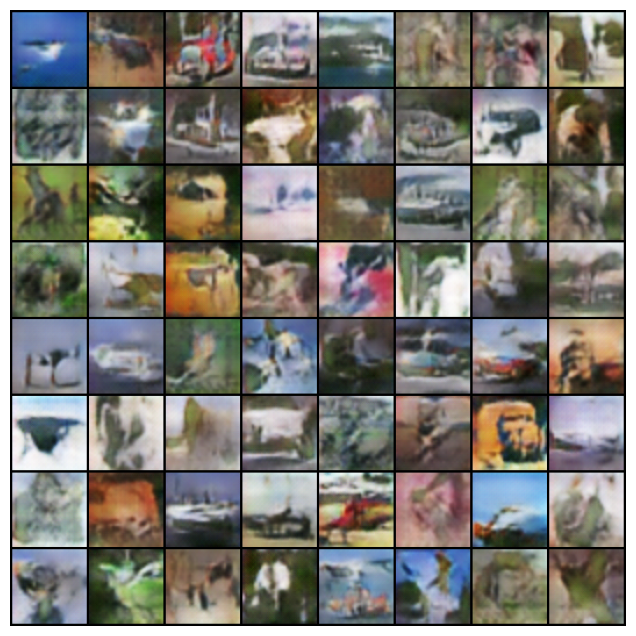

Epoch [30/200] | D Loss: 0.250 | G Loss: 3.424
Epoch [40/200] | D Loss: 0.375 | G Loss: 2.863


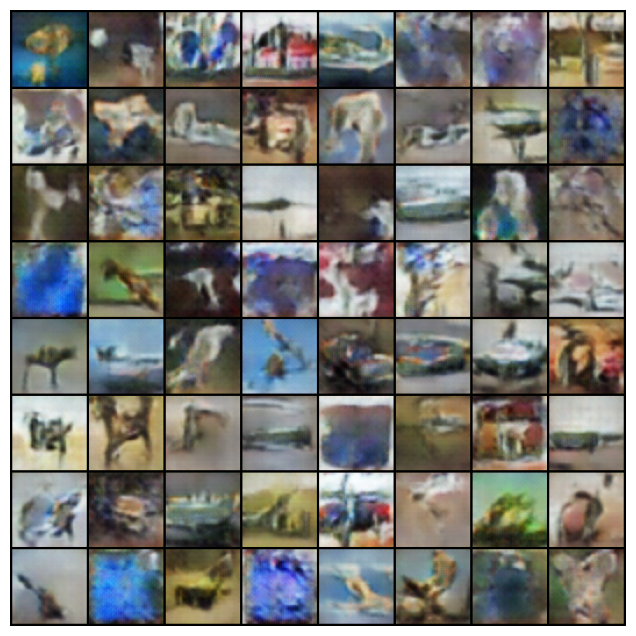

Epoch [50/200] | D Loss: 0.008 | G Loss: 7.351
Epoch [60/200] | D Loss: 0.102 | G Loss: 5.070


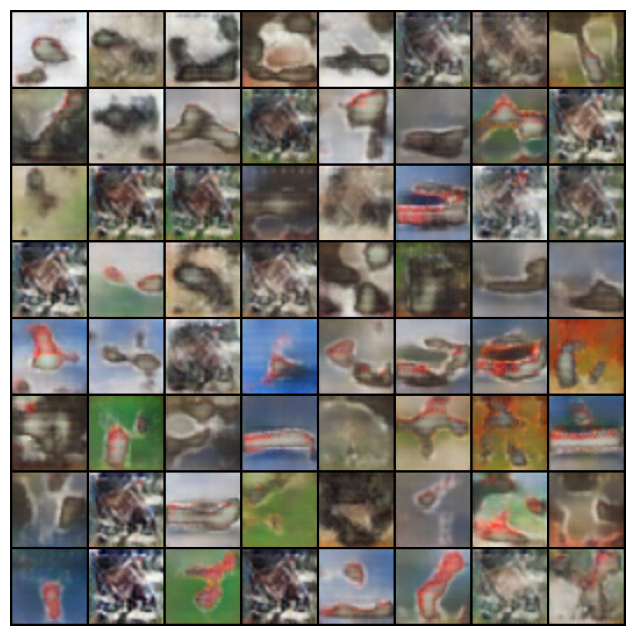

Epoch [70/200] | D Loss: 0.012 | G Loss: 6.789
Epoch [80/200] | D Loss: 0.000 | G Loss: 14.991


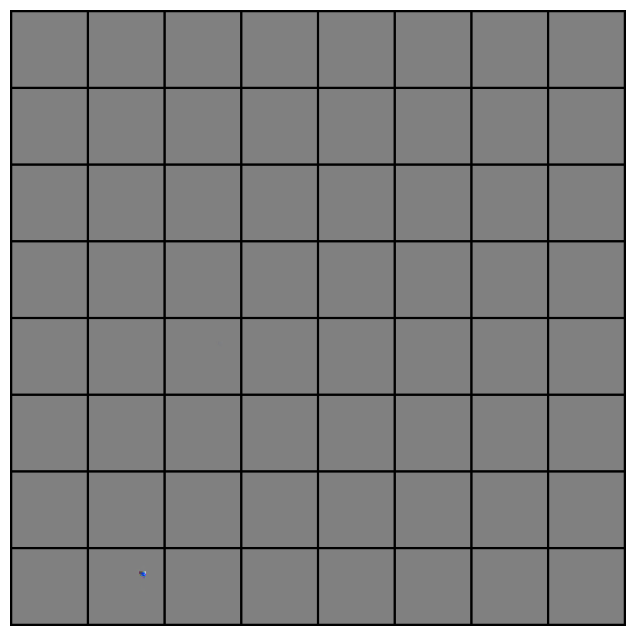

Epoch [90/200] | D Loss: 0.189 | G Loss: 5.072
Epoch [100/200] | D Loss: 0.018 | G Loss: 5.342


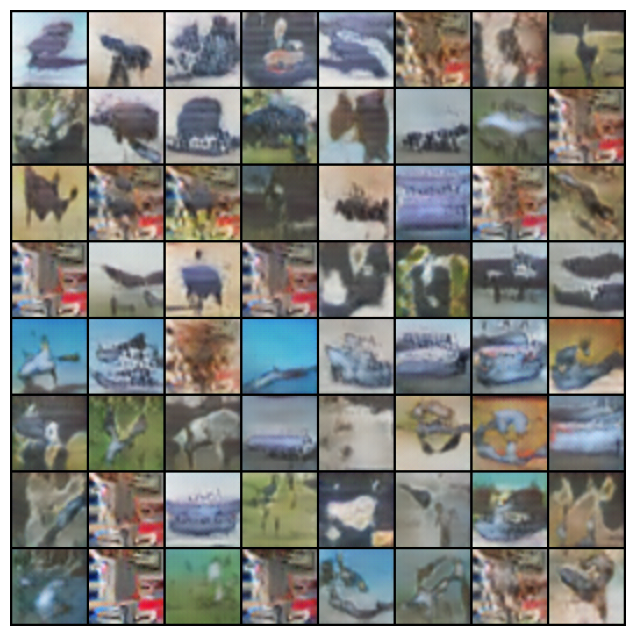

Epoch [110/200] | D Loss: 0.450 | G Loss: 2.167
Epoch [120/200] | D Loss: 0.021 | G Loss: 7.180


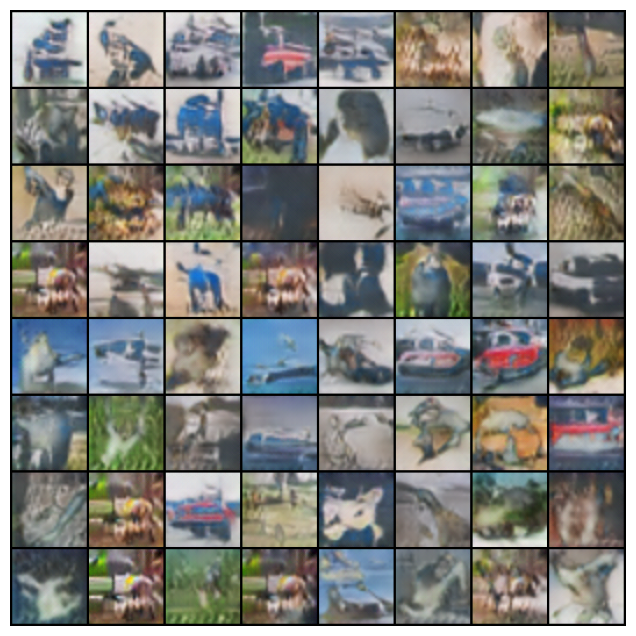

Epoch [130/200] | D Loss: 0.081 | G Loss: 4.446
Epoch [140/200] | D Loss: 1.412 | G Loss: 5.910


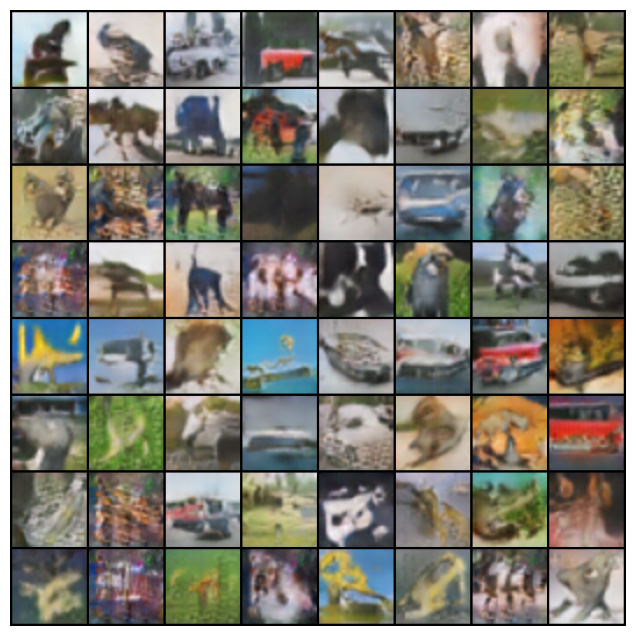

Epoch [150/200] | D Loss: 0.374 | G Loss: 1.793
Epoch [160/200] | D Loss: 0.353 | G Loss: 4.155


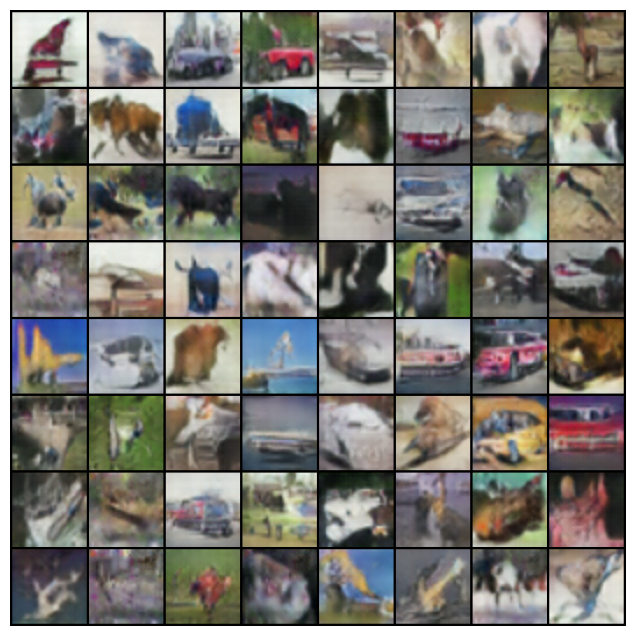

Epoch [170/200] | D Loss: 0.294 | G Loss: 2.153
Epoch [180/200] | D Loss: 0.126 | G Loss: 4.816


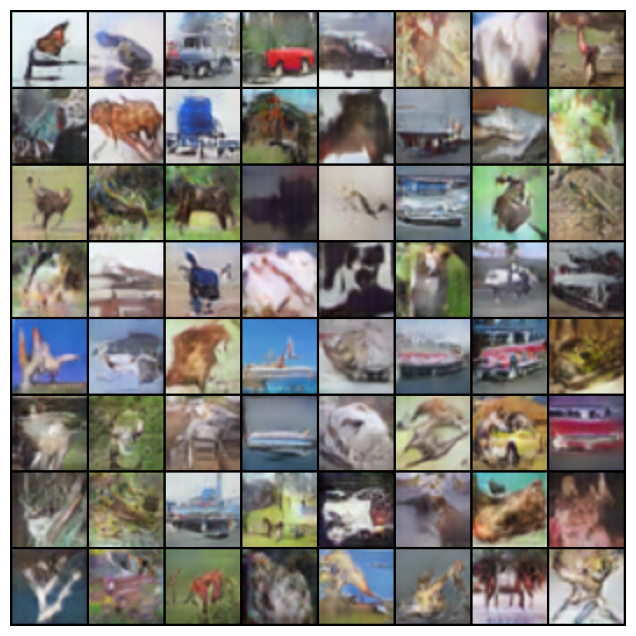

Epoch [190/200] | D Loss: 0.738 | G Loss: 0.372
Epoch [200/200] | D Loss: 0.000 | G Loss: 9.958


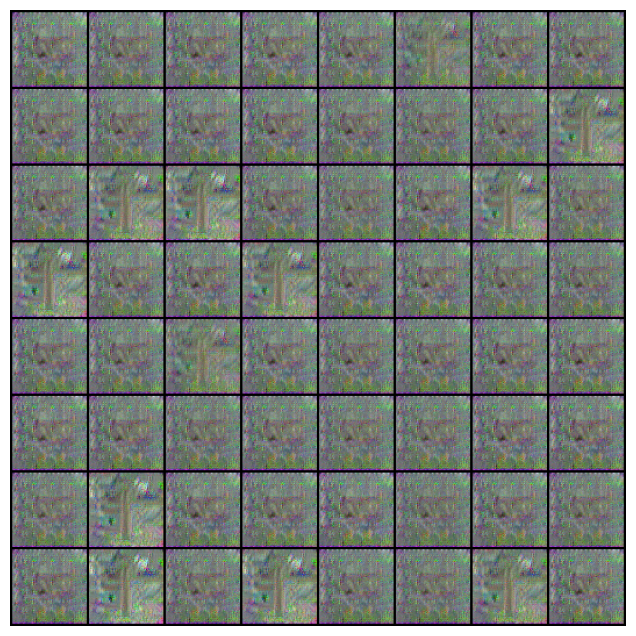

In [7]:
epochs = 200
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(epochs):
    for i, (real, _) in enumerate(dataloader):
        real = real.to(device)
        b_size = real.size(0)
        label_real = torch.full((b_size,), 1., device=device)
        label_fake = torch.full((b_size,), 0., device=device)

        netD.zero_grad()
        output_real = netD(real).view(-1)
        lossD_real = criterion(output_real, label_real)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output_fake = netD(fake.detach()).view(-1)
        lossD_fake = criterion(output_fake, label_fake)
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        netG.zero_grad()
        output_fake2 = netD(fake).view(-1)
        lossG = criterion(output_fake2, label_real)
        lossG.backward()
        optimizerG.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {lossD.item():.3f} | G Loss: {lossG.item():.3f}")

    if (epoch+1) % 20 == 0:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        grid = make_grid(fake, padding=2, normalize=True)
        plt.figure(figsize=(8,8))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()